<a href="https://colab.research.google.com/github/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Sign_OPT_Attack_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [ ]:
!git clone https://github.com/ndb796/attackbox

Cloning into 'attackbox'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 594 (delta 7), reused 14 (delta 6), pack-reused 575
Receiving objects: 100% (594/594), 74.55 MiB | 34.92 MiB/s, done.
Resolving deltas: 100% (298/298), done.
Checking out files: 100% (191/191), done.


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

import os
import time
import shutil

#### <b>Load Dataset</b>

In [ ]:
def load_model(model, filename):
    """ Load the training model """
    model.load_state_dict(torch.load(filename))


def load_mnist_data(batch_size=1):
    """ Load MNIST data from torchvision.datasets 
        input: None
        output: minibatches of train and test sets 
    """
    # MNIST Dataset
    train_dataset = torchvision.datasets.MNIST(root='./data/mnist', train=True, transform=torchvision.transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data/mnist', train=False, transform=torchvision.transforms.ToTensor())

    # Data Loader (Input Pipeline)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset


test_batch_size = 1
train_loader, test_loader, train_dataset, test_dataset = load_mnist_data(test_batch_size)

#### <b>Load Pre-trained Classification Model</b>

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()        
        self.main = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2))
        self.fc = nn.Sequential(
            nn.Linear(4*4*50, 500),    
            nn.ReLU(),            
            nn.Linear(500, 10))
    def forward(self, x):
        x = self.main(x)
        x = x.view(-1, 4*4*50)
        x = self.fc(x)
        return x


model_dir = 'attackbox/model/m_cnn'
net = BasicCNN()
load_model(net, model_dir)
net = torch.nn.DataParallel(net, device_ids=[0])
net.cuda()
net.eval()

DataParallel(
  (module): BasicCNN(
    (main): Sequential(
      (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=800, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=10, bias=True)
    )
  )
)

In [ ]:
class PytorchModel(object):
    def __init__(self,model, bounds, num_classes):
        self.model = model
        self.model.eval()
        self.bounds = bounds
        self.num_classes = num_classes
        self.num_queries = 0

    def predict(self,image):
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        output = self.model(image)
        self.num_queries += 1
        return output
 
    def predict_prob(self,image):
        with torch.no_grad():
            image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
            if len(image.size())!=4:
                image = image.unsqueeze(0)
            output = self.model(image)
            self.num_queries += image.size(0)
        return output

    def predict_label(self, image, batch=False):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).type(torch.FloatTensor)
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        with torch.no_grad():
            output = self.model(image)
            self.num_queries += image.size(0)
        _, predict = torch.max(output.data, 1)
        if batch:
            return predict
        else:
            return predict[0]

    def predict_ensemble(self, image):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).type(torch.FloatTensor)
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        with torch.no_grad():
            output = self.model(image)
            output.zero_()
            for i in range(10):
                output += self.model(image)
                self.num_queries += image.size(0)

        _, predict = torch.max(output.data, 1)

        return predict[0]

    def get_num_queries(self):
        return self.num_queries

    def get_gradient(self,loss):
        loss.backward()

#### <b>Adversarial Attack</b>

In [ ]:
start_learning_rate = 1.0
MAX_ITER = 1000


def quad_solver(Q, b):
    """
    Solve min_a  0.5*aQa + b^T a s.t. a>=0
    """
    K = Q.shape[0]
    alpha = np.zeros((K,))
    g = b
    Qdiag = np.diag(Q)
    for i in range(20000):
        delta = np.maximum(alpha - g / Qdiag, 0) - alpha
        idx = np.argmax(abs(delta))
        val = delta[idx]
        if abs(val) < 1e-7: 
            break
        g = g + val * Q[:,idx]
        alpha[idx] += val
    return alpha


def sign(y):
    """
    y -- numpy array of shape (m,)
    Returns an element-wise indication of the sign of a number.
    The sign function returns -1 if y < 0, 1 if x >= 0. nan is returned for nan inputs.
    """
    y_sign = np.sign(y)
    y_sign[y_sign==0] = 1
    return y_sign


class OPT_attack_sign_SGD(object):
    def __init__(self, model, k=200, train_dataset=None):
        self.model = model
        self.k = k
        self.train_dataset = train_dataset 
        self.log = torch.ones(MAX_ITER, 2)

    def get_log(self):
        return self.log

    def attack_untargeted(self, x0, y0, alpha = 0.2, beta = 0.001, iterations = 1000, query_limit=20000,
                          distortion=None, svm=False, momentum=0.0, stopping=0.0001):
        """ Attack the original image and return adversarial example
            model: (pytorch model)
            train_dataset: set of training data
            (x0, y0): original image
        """
        model = self.model
        y0 = y0[0]
        query_count = 0
        ls_total = 0

        if (model.predict_label(x0) != y0):
            print("Fail to classify the image. No need to attack.")
            return x0, 0, True, 0, None

        # 공격을 위한 초기 방향(initial direction) theta 찾기 / g_theta: 거리(짧을수록 좋음)
        # init: Calculate a good starting point (direction)
        num_directions = 100
        best_theta, g_theta = None, float('inf')
        print("Searching for the initial direction on %d random directions: " % (num_directions))
        timestart = time.time()
        for i in range(num_directions):
            query_count += 1
            theta = np.random.randn(*x0.shape) # gaussian distortion
            # register adv directions
            if model.predict_label(x0 + torch.tensor(theta, dtype=torch.float).cuda()) != y0: 
                initial_lbd = LA.norm(theta)
                theta /= initial_lbd # l2 normalize
                lbd, count = self.fine_grained_binary_search(model, x0, y0, theta, initial_lbd, g_theta)
                query_count += count
                if lbd < g_theta:
                    best_theta, g_theta = theta, lbd
                    print("--------> Found distortion %.4f" % g_theta)
        timeend = time.time()
        
        # fail if cannot find a adv direction within 200 Gaussian
        if g_theta == float('inf'):
            print("Couldn't find valid initial, failed")
            return x0, 0, False, query_count, best_theta
        print("==========> Found best distortion %.4f in %.4f seconds "
              "using %d queries" % (g_theta, timeend-timestart, query_count))
        self.log[0][0], self.log[0][1] = g_theta, query_count

        # 반복적으로 theta를 업데이트하며 공격 수행
        # Begin Gradient Descent.
        timestart = time.time()
        xg, gg = best_theta, g_theta
        vg = np.zeros_like(xg)
        learning_rate = start_learning_rate
        prev_obj = 100000
        distortions = [gg]
        for i in range(iterations):
            # 기울기(gradient) 예측
            # gradient estimation at x0 + theta (init)
            if svm == True:
                sign_gradient, grad_queries = self.sign_grad_svm(x0, y0, xg, initial_lbd=gg, h=beta)
            else:
                sign_gradient, grad_queries = self.sign_grad_v1(x0, y0, xg, initial_lbd=gg, h=beta)

            # Line search of the step size of gradient descent
            ls_count = 0
            min_theta = xg # next theta
            min_g2 = gg # current g_theta
            min_vg = vg # velocity (for momentum only)
            for _ in range(15):
                # update theta by one step sgd
                if momentum > 0:
                    new_vg = momentum * vg - alpha*sign_gradient
                    new_theta = xg + new_vg
                else:
                    new_theta = xg - alpha * sign_gradient
                new_theta /= LA.norm(new_theta)

                new_g2, count = self.fine_grained_binary_search_local(
                    model, x0, y0, new_theta, initial_lbd = min_g2, tol=beta/500)
                ls_count += count
                alpha = alpha * 2 # gradually increasing step size
                if new_g2 < min_g2:
                    min_theta = new_theta
                    min_g2 = new_g2
                    if momentum > 0:
                        min_vg = new_vg
                else:
                    break

            if min_g2 >= gg: # if the above code failed for the init alpha, we then try to decrease alpha
                for _ in range(15):
                    alpha = alpha * 0.25
                    if momentum > 0:
                        new_vg = momentum * vg - alpha * sign_gradient
                        new_theta = xg + new_vg
                    else:
                        new_theta = xg - alpha * sign_gradient
                    new_theta /= LA.norm(new_theta)
                    new_g2, count = self.fine_grained_binary_search_local(
                        model, x0, y0, new_theta, initial_lbd = min_g2, tol=beta/500)
                    ls_count += count
                    if new_g2 < gg:
                        min_theta = new_theta 
                        min_g2 = new_g2
                        if momentum > 0:
                            min_vg = new_vg
                        break

            if alpha < 1e-4: # if the above two blocks of code failed
                alpha = 1.0
                print("Warning: not moving")
                beta = beta * 0.1
                if (beta < 1e-8):
                    break
            
            # if all attemps failed, min_theta, min_g2 will be the current theta (i.e. not moving)
            xg, gg = min_theta, min_g2
            vg = min_vg

            query_count += (grad_queries + ls_count)
            ls_total += ls_count
            distortions.append(gg)

            if query_count > query_limit:
                break

            # 공격이 진행되는 상황에서 로깅(logging)
            if (i + 1) % 10 == 0:
                print("Iteration %3d distortion %.4f num_queries %d" % (i+1, gg, query_count))
            self.log[i + 1][0], self.log[i + 1][1] = gg, query_count

            if (i + 1) % 100 == 0:
                # 화면에 이미지 출력하기
                img = x0.cpu() + torch.tensor(gg * xg, dtype=torch.float) # [batch_size, 1, H, W]
                img = torch.clamp(img, min=0, max=1).squeeze(0) # [1, H, W]
                img = torchvision.transforms.ToPILImage()(img)
                plt.imshow(img, cmap='gray') # for grayscale
                plt.show()

        if distortion is None or gg < distortion:
            target = model.predict_label(x0 + torch.tensor(gg * xg, dtype=torch.float).cuda())
            print("Succeed distortion {:.4f} target"
                  " {:d} queries {:d} LS queries {:d}\n".format(gg, target, query_count, ls_total))
            return x0 + torch.tensor(gg * xg, dtype=torch.float).cuda(), gg, True, query_count, xg

        timeend = time.time()
        print("\nFailed: distortion %.4f" % (gg))
        
        self.log[i+1:,0] = gg
        self.log[i+1:,1] = query_count
        return x0 + torch.tensor(gg * xg, dtype=torch.float).cuda(), gg, False, query_count, xg


    def sign_grad_v1(self, x0, y0, theta, initial_lbd, h=0.001, D=4, target=None):
        """
        Evaluate the sign of gradient by formulat
        sign(g) = 1/Q [ \sum_{q=1}^Q sign( g(theta+h*u_i) - g(theta) )u_i$ ]
        """
        K = self.k # 200 random directions (for estimating the gradient)
        sign_grad = np.zeros(theta.shape)
        queries = 0

        for iii in range(K): # for each u
            u = np.random.randn(*theta.shape); u /= LA.norm(u)
            new_theta = theta + h * u; new_theta /= LA.norm(new_theta)
            sign = 1
            
            # Targeted case
            if (target is not None and 
                self.model.predict_label(x0 + torch.tensor(initial_lbd * new_theta, dtype=torch.float).cuda()) == target):
                sign = -1

            # Untargeted case
            if (target is None and
                self.model.predict_label(x0 + torch.tensor(initial_lbd * new_theta, dtype=torch.float).cuda()) != y0): # success
                sign = -1

            queries += 1
            sign_grad += u*sign
        
        sign_grad /= K
        
        return sign_grad, queries


    def sign_grad_svm(self, x0, y0, theta, initial_lbd, h=0.001, K=100, lr=5.0, target=None):
        """
        Evaluate the sign of gradient by formulat
        sign(g) = 1/Q [ \sum_{q=1}^Q sign( g(theta+h*u_i) - g(theta) )u_i$ ]
        """
        sign_grad = np.zeros(theta.shape)
        queries = 0
        dim = np.prod(theta.shape)
        X = np.zeros((dim, K))
        for iii in range(K):
            u = np.random.randn(*theta.shape)
            u /= LA.norm(u)
            
            sign = 1
            new_theta = theta + h * u
            new_theta /= LA.norm(new_theta)            
            
            # Targeted case
            if (target is not None and 
                self.model.predict_label(x0 + torch.tensor(initial_lbd * new_theta, dtype=torch.float).cuda()) == target):
                sign = -1
                
            # Untargeted case
            if (target is None and
                self.model.predict_label(x0 + torch.tensor(initial_lbd * new_theta, dtype=torch.float).cuda()) != y0):
                sign = -1
                
            queries += 1
            X[:,iii] = sign * u.reshape((dim,))
        
        Q = X.transpose().dot(X)
        q = -1 * np.ones((K,))
        G = np.diag(-1 * np.ones((K,)))
        h = np.zeros((K,))
        alpha = quad_solver(Q, q)
        sign_grad = (X.dot(alpha)).reshape(theta.shape)
        
        return sign_grad, queries


    def fine_grained_binary_search_local(self, model, x0, y0, theta, initial_lbd = 1.0, tol=1e-5):
        nquery = 0
        lbd = initial_lbd
         
        # still inside boundary
        if model.predict_label(x0 + torch.tensor(lbd * theta, dtype=torch.float).cuda()) == y0:
            lbd_lo = lbd
            lbd_hi = lbd * 1.01
            nquery += 1
            while model.predict_label(x0 + torch.tensor(lbd_hi * theta, dtype=torch.float).cuda()) == y0:
                lbd_hi = lbd_hi * 1.01
                nquery += 1
                if lbd_hi > 20:
                    return float('inf'), nquery
        else:
            lbd_hi = lbd
            lbd_lo = lbd * 0.99
            nquery += 1
            while model.predict_label(x0 + torch.tensor(lbd_lo * theta, dtype=torch.float).cuda()) != y0 :
                lbd_lo = lbd_lo * 0.99
                nquery += 1

        while (lbd_hi - lbd_lo) > tol:
            lbd_mid = (lbd_lo + lbd_hi) / 2.0
            nquery += 1
            if model.predict_label(x0 + torch.tensor(lbd_mid * theta, dtype=torch.float).cuda()) != y0:
                lbd_hi = lbd_mid
            else:
                lbd_lo = lbd_mid
        return lbd_hi, nquery


    def fine_grained_binary_search(self, model, x0, y0, theta, initial_lbd, current_best):
        nquery = 0
        if initial_lbd > current_best: 
            if model.predict_label(x0 + torch.tensor(current_best * theta, dtype=torch.float).cuda()) == y0:
                nquery += 1
                return float('inf'), nquery
            lbd = current_best
        else:
            lbd = initial_lbd

        lbd_hi = lbd
        lbd_lo = 0.0
        
        while (lbd_hi - lbd_lo) > 1e-3: # was 1e-5
            lbd_mid = (lbd_lo + lbd_hi) / 2.0
            nquery += 1
            if model.predict_label(x0 + torch.tensor(lbd_mid*theta, dtype=torch.float).cuda()) != y0:
                lbd_hi = lbd_mid
            else:
                lbd_lo = lbd_mid
        return lbd_hi, nquery


    def __call__(self, input_xi, label_or_target, targeted=False, distortion=None, seed=None,
                 svm=False, query_limit=4000, momentum=0.0, stopping=0.0001, args=None):
        if targeted:
            raise NotImplementedError
        else:
            adv = self.attack_untargeted(input_xi, label_or_target, distortion=distortion,
                                         svm=svm, query_limit=query_limit, momentum=momentum,
                                         stopping=stopping)
        return adv

In [ ]:
# 단순히 p-norm 거리(distance) 계산
def distance(x_adv, x, norm='l2'):
    diff = (x_adv - x).view(x.size(0), -1)
    if norm == 'l2':
        out = torch.sqrt(torch.sum(diff * diff)).item()
        return out
    elif norm == 'linf':
        out = torch.sum(torch.max(torch.abs(diff), 1)[0]).item()
        return out

In [ ]:
from types import SimpleNamespace

args = SimpleNamespace()

args.targeted = False # Targeted attack.
args.random_start = False # PGD attack with random start.
args.epsilon = 2.0
args.seed = 123
args.norm = 'l2'
args.test_batch = 40 # The number of test batch.
args.query = 80000

image batch: 0
Searching for the initial direction on 100 random directions: 
--------> Found distortion 25.5910
--------> Found distortion 20.5483
--------> Found distortion 13.3080
==========> Found best distortion 13.3080 in 0.1645 seconds using 231 queries
Iteration  10 distortion 2.5259 num_queries 3159
Iteration  20 distortion 2.1667 num_queries 5648
Iteration  30 distortion 2.0685 num_queries 8080
Iteration  40 distortion 2.0371 num_queries 10463
Iteration  50 distortion 2.0105 num_queries 12833
Iteration  60 distortion 1.9973 num_queries 15226
Iteration  70 distortion 1.9915 num_queries 17586
Iteration  80 distortion 1.9863 num_queries 19931
Iteration  90 distortion 1.9817 num_queries 22336
Iteration 100 distortion 1.9778 num_queries 24681


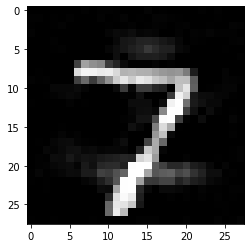

Iteration 110 distortion 1.9753 num_queries 27026
Iteration 120 distortion 1.9728 num_queries 29416
Succeed distortion 1.9728 target 2 queries 32095 LS queries 6664



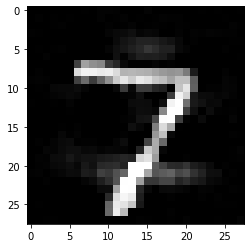

image batch: 1
Searching for the initial direction on 100 random directions: 
--------> Found distortion 16.6903
--------> Found distortion 15.5137
--------> Found distortion 15.3783
--------> Found distortion 15.2826
==========> Found best distortion 15.2826 in 0.1737 seconds using 237 queries
Iteration  10 distortion 3.7677 num_queries 3161
Iteration  20 distortion 3.0972 num_queries 5708
Iteration  30 distortion 2.9369 num_queries 8181
Iteration  40 distortion 2.8667 num_queries 10568
Iteration  50 distortion 2.8132 num_queries 12943
Iteration  60 distortion 2.7811 num_queries 15317
Iteration  70 distortion 2.7554 num_queries 17653
Iteration  80 distortion 2.7378 num_queries 20006
Iteration  90 distortion 2.7219 num_queries 22400
Iteration 100 distortion 2.7082 num_queries 24749


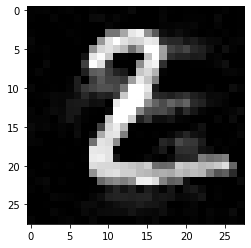

Iteration 110 distortion 2.7009 num_queries 27154
Iteration 120 distortion 2.6960 num_queries 29529
Iteration 130 distortion 2.6924 num_queries 31919
Iteration 140 distortion 2.6888 num_queries 34309
Iteration 150 distortion 2.6843 num_queries 36639
Iteration 160 distortion 2.6809 num_queries 38999
Iteration 170 distortion 2.6790 num_queries 41805

Failed: distortion 2.6790


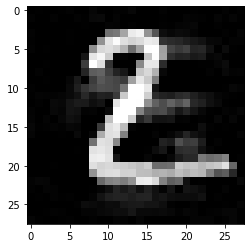

image batch: 2
Searching for the initial direction on 100 random directions: 
--------> Found distortion 11.3771
--------> Found distortion 10.3015
--------> Found distortion 8.5032
--------> Found distortion 6.9063
==========> Found best distortion 6.9063 in 0.1931 seconds using 253 queries
Iteration  10 distortion 1.6945 num_queries 3159
Iteration  20 distortion 1.4186 num_queries 5621
Iteration  30 distortion 1.3528 num_queries 8018
Iteration  40 distortion 1.3272 num_queries 10393
Iteration  50 distortion 1.3055 num_queries 12720
Iteration  60 distortion 1.2949 num_queries 15054
Iteration  70 distortion 1.2886 num_queries 17394
Iteration  80 distortion 1.2833 num_queries 19730
Iteration  90 distortion 1.2805 num_queries 22052
Iteration 100 distortion 1.2787 num_queries 24388


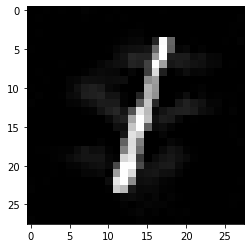

Iteration 110 distortion 1.2776 num_queries 26682
Iteration 120 distortion 1.2760 num_queries 29018
Iteration 130 distortion 1.2754 num_queries 31368
Iteration 140 distortion 1.2747 num_queries 33718
Succeed distortion 1.2746 target 8 queries 36486 LS queries 6833



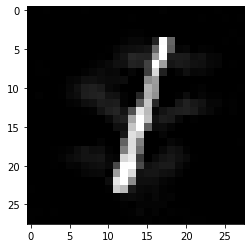

image batch: 3
Searching for the initial direction on 100 random directions: 
--------> Found distortion 27.0632
--------> Found distortion 27.0169
--------> Found distortion 21.5984
--------> Found distortion 17.4228
--------> Found distortion 16.6055
==========> Found best distortion 16.6055 in 0.1658 seconds using 213 queries
Iteration  10 distortion 3.2003 num_queries 3143
Iteration  20 distortion 2.4151 num_queries 5796
Iteration  30 distortion 2.2496 num_queries 8194
Iteration  40 distortion 2.1689 num_queries 10639
Iteration  50 distortion 2.1250 num_queries 13038
Iteration  60 distortion 2.1022 num_queries 15409
Iteration  70 distortion 2.0831 num_queries 17820
Iteration  80 distortion 2.0743 num_queries 20155
Iteration  90 distortion 2.0664 num_queries 22533
Iteration 100 distortion 2.0595 num_queries 24893


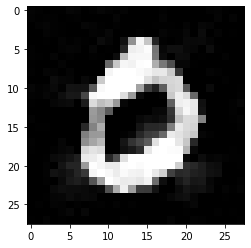

Iteration 110 distortion 2.0562 num_queries 27268
Iteration 120 distortion 2.0529 num_queries 29673
Iteration 130 distortion 2.0498 num_queries 32063
Iteration 140 distortion 2.0493 num_queries 35689

Failed: distortion 2.0493


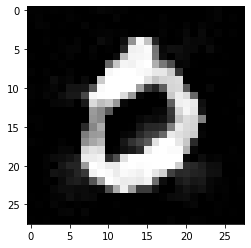

image batch: 4
Searching for the initial direction on 100 random directions: 
--------> Found distortion 21.4078
--------> Found distortion 20.8551
--------> Found distortion 17.9650
--------> Found distortion 16.5911
--------> Found distortion 13.2291
==========> Found best distortion 13.2291 in 0.1623 seconds using 213 queries
Iteration  10 distortion 2.3195 num_queries 3060
Iteration  20 distortion 1.6858 num_queries 5662
Iteration  30 distortion 1.5328 num_queries 8063
Iteration  40 distortion 1.4644 num_queries 10439
Iteration  50 distortion 1.4300 num_queries 12819
Iteration  60 distortion 1.4068 num_queries 15241
Iteration  70 distortion 1.3986 num_queries 17628
Iteration  80 distortion 1.3900 num_queries 19982
Succeed distortion 1.3900 target 9 queries 22214 LS queries 5001



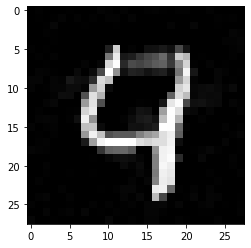

image batch: 5
Searching for the initial direction on 100 random directions: 
--------> Found distortion 12.1397
--------> Found distortion 10.1095
--------> Found distortion 10.0546
--------> Found distortion 10.0294
--------> Found distortion 9.9137
--------> Found distortion 9.4115
--------> Found distortion 9.0737
==========> Found best distortion 9.0737 in 0.2309 seconds using 292 queries
Iteration  10 distortion 2.4581 num_queries 3180
Iteration  20 distortion 1.9452 num_queries 5758
Iteration  30 distortion 1.8227 num_queries 8199
Iteration  40 distortion 1.7706 num_queries 10589
Iteration  50 distortion 1.7496 num_queries 12973
Iteration  60 distortion 1.7348 num_queries 15324
Iteration  70 distortion 1.7266 num_queries 17717
Iteration  80 distortion 1.7222 num_queries 20092
Iteration  90 distortion 1.7194 num_queries 22437
Iteration 100 distortion 1.7171 num_queries 24812


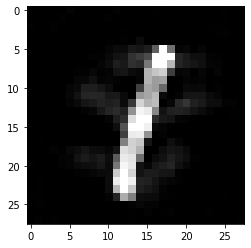

Iteration 110 distortion 1.7159 num_queries 27157
Iteration 120 distortion 1.7150 num_queries 29682
Iteration 130 distortion 1.7150 num_queries 33018
Succeed distortion 1.7150 target 8 queries 33018 LS queries 6726



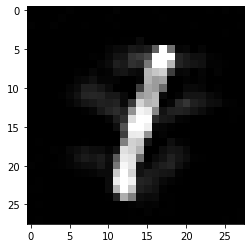

image batch: 6
Searching for the initial direction on 100 random directions: 
--------> Found distortion 17.4475
--------> Found distortion 17.0817
--------> Found distortion 12.2394
--------> Found distortion 9.4896
--------> Found distortion 8.1227
--------> Found distortion 7.6190
==========> Found best distortion 7.6190 in 0.2042 seconds using 271 queries
Iteration  10 distortion 1.3166 num_queries 3205
Iteration  20 distortion 1.1370 num_queries 5722
Iteration  30 distortion 1.0774 num_queries 8121
Iteration  40 distortion 1.0484 num_queries 10496
Iteration  50 distortion 1.0348 num_queries 12840
Iteration  60 distortion 1.0282 num_queries 15137
Iteration  70 distortion 1.0225 num_queries 17543
Iteration  80 distortion 1.0185 num_queries 19882
Iteration  90 distortion 1.0152 num_queries 22232
Iteration 100 distortion 1.0126 num_queries 24554


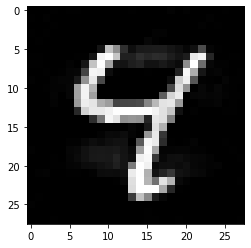

Iteration 110 distortion 1.0111 num_queries 27143
Iteration 120 distortion 1.0111 num_queries 30275
Succeed distortion 1.0111 target 8 queries 30715 LS queries 6244



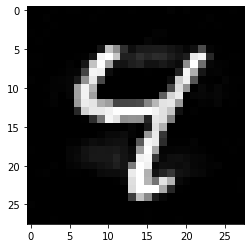

image batch: 7
Searching for the initial direction on 100 random directions: 
--------> Found distortion 9.3488
--------> Found distortion 8.1129
--------> Found distortion 7.0274
==========> Found best distortion 7.0274 in 0.1817 seconds using 239 queries
Iteration  10 distortion 1.6871 num_queries 3187
Iteration  20 distortion 1.4176 num_queries 5712
Iteration  30 distortion 1.3392 num_queries 8113
Iteration  40 distortion 1.2988 num_queries 10538
Iteration  50 distortion 1.2784 num_queries 12940
Iteration  60 distortion 1.2624 num_queries 15284
Iteration  70 distortion 1.2521 num_queries 17632
Iteration  80 distortion 1.2450 num_queries 20005
Iteration  90 distortion 1.2390 num_queries 22425
Iteration 100 distortion 1.2358 num_queries 24775


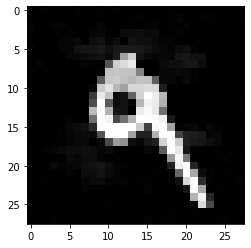

Iteration 110 distortion 1.2321 num_queries 27125
Iteration 120 distortion 1.2311 num_queries 29730
Succeed distortion 1.2311 target 4 queries 32093 LS queries 6654



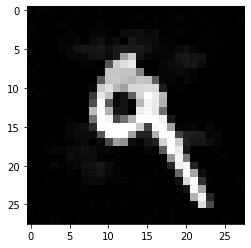

image batch: 8
Searching for the initial direction on 100 random directions: 
--------> Found distortion 15.9077
--------> Found distortion 10.7278
--------> Found distortion 10.5196
==========> Found best distortion 10.5196 in 0.1872 seconds using 239 queries
Iteration  10 distortion 1.6334 num_queries 3143
Iteration  20 distortion 1.3695 num_queries 5655
Iteration  30 distortion 1.3080 num_queries 8040
Iteration  40 distortion 1.2788 num_queries 10368
Iteration  50 distortion 1.2669 num_queries 12710
Iteration  60 distortion 1.2587 num_queries 15120
Iteration  70 distortion 1.2540 num_queries 17442
Iteration  80 distortion 1.2506 num_queries 19806
Iteration  90 distortion 1.2475 num_queries 22156
Iteration 100 distortion 1.2462 num_queries 25387


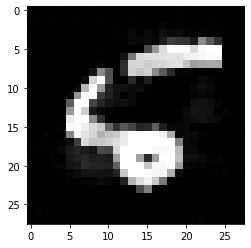

Succeed distortion 1.2462 target 6 queries 25387 LS queries 5148



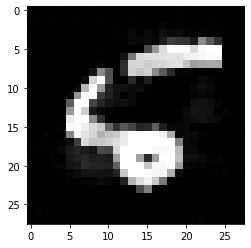

image batch: 9
Searching for the initial direction on 100 random directions: 
--------> Found distortion 11.9660
--------> Found distortion 9.6800
--------> Found distortion 8.5663
--------> Found distortion 7.0537
==========> Found best distortion 7.0537 in 0.1843 seconds using 253 queries
Iteration  10 distortion 1.3367 num_queries 3233
Iteration  20 distortion 1.1319 num_queries 5731
Iteration  30 distortion 1.0728 num_queries 8106
Iteration  40 distortion 1.0469 num_queries 10515
Iteration  50 distortion 1.0320 num_queries 12905
Iteration  60 distortion 1.0142 num_queries 15260
Iteration  70 distortion 1.0049 num_queries 17769
Iteration  80 distortion 1.0048 num_queries 20297
Succeed distortion 1.0048 target 4 queries 21723 LS queries 4670



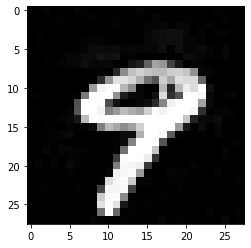

image batch: 10
Searching for the initial direction on 100 random directions: 
--------> Found distortion 21.6580
--------> Found distortion 20.1782
--------> Found distortion 19.3321
--------> Found distortion 17.9746
==========> Found best distortion 17.9746 in 0.1674 seconds using 225 queries
Iteration  10 distortion 3.3302 num_queries 3247
Iteration  20 distortion 2.8202 num_queries 5697
Iteration  30 distortion 2.6507 num_queries 8161
Iteration  40 distortion 2.5916 num_queries 10572
Iteration  50 distortion 2.5685 num_queries 12956
Iteration  60 distortion 2.5538 num_queries 15366
Iteration  70 distortion 2.5447 num_queries 17728
Iteration  80 distortion 2.5395 num_queries 20103
Iteration  90 distortion 2.5394 num_queries 23607

Failed: distortion 2.5394


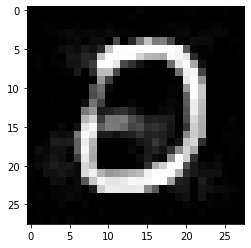

image batch: 11
Searching for the initial direction on 100 random directions: 
--------> Found distortion 12.1545
--------> Found distortion 9.9638
==========> Found best distortion 9.9638 in 0.1693 seconds using 227 queries
Iteration  10 distortion 2.4090 num_queries 3178
Iteration  20 distortion 1.9974 num_queries 5667
Iteration  30 distortion 1.8683 num_queries 8123
Iteration  40 distortion 1.8250 num_queries 10509
Iteration  50 distortion 1.8057 num_queries 14107
Succeed distortion 1.8057 target 8 queries 14107 LS queries 3880



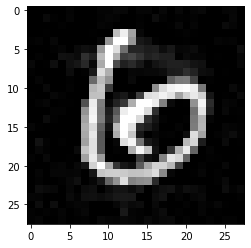

image batch: 12
Searching for the initial direction on 100 random directions: 
--------> Found distortion 15.8934
--------> Found distortion 9.4037
--------> Found distortion 7.5033
--------> Found distortion 7.0637
==========> Found best distortion 7.0637 in 0.1907 seconds using 252 queries
Iteration  10 distortion 1.3769 num_queries 3112
Iteration  20 distortion 1.1851 num_queries 5638
Iteration  30 distortion 1.1179 num_queries 8127
Iteration  40 distortion 1.0975 num_queries 10502
Iteration  50 distortion 1.0792 num_queries 12844
Iteration  60 distortion 1.0612 num_queries 15214
Iteration  70 distortion 1.0498 num_queries 17611
Iteration  80 distortion 1.0290 num_queries 19990
Iteration  90 distortion 1.0164 num_queries 22365
Iteration 100 distortion 1.0063 num_queries 24706


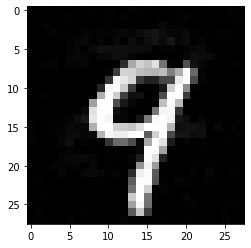

Iteration 110 distortion 0.9958 num_queries 27020
Iteration 120 distortion 0.9884 num_queries 29431
Iteration 130 distortion 0.9859 num_queries 32238
Succeed distortion 0.9859 target 4 queries 34491 LS queries 7039



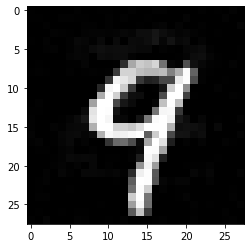

image batch: 13
Searching for the initial direction on 100 random directions: 
--------> Found distortion 25.7919
--------> Found distortion 24.2437
--------> Found distortion 23.4128
--------> Found distortion 18.7014
--------> Found distortion 17.6336
--------> Found distortion 17.1406
--------> Found distortion 16.6515
==========> Found best distortion 16.6515 in 0.2107 seconds using 260 queries
Iteration  10 distortion 3.7055 num_queries 3133
Iteration  20 distortion 3.0857 num_queries 5688
Iteration  30 distortion 2.9219 num_queries 8167
Iteration  40 distortion 2.8529 num_queries 10525
Iteration  50 distortion 2.8180 num_queries 12940
Iteration  60 distortion 2.7999 num_queries 15323
Iteration  70 distortion 2.7891 num_queries 17691
Iteration  80 distortion 2.7813 num_queries 20051
Iteration  90 distortion 2.7767 num_queries 22411
Iteration 100 distortion 2.7741 num_queries 24741


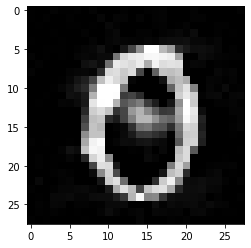

Iteration 110 distortion 2.7710 num_queries 27101
Iteration 120 distortion 2.7693 num_queries 29521
Iteration 130 distortion 2.7676 num_queries 31911
Iteration 140 distortion 2.7667 num_queries 34316
Iteration 150 distortion 2.7658 num_queries 36721
Iteration 160 distortion 2.7649 num_queries 39036
Iteration 170 distortion 2.7645 num_queries 41426
Iteration 180 distortion 2.7639 num_queries 43756
Iteration 190 distortion 2.7637 num_queries 46131
Iteration 200 distortion 2.7637 num_queries 49410


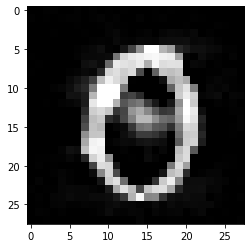


Failed: distortion 2.7637


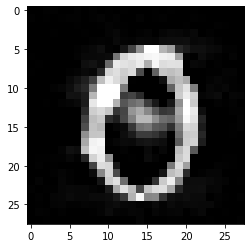

image batch: 14
Searching for the initial direction on 100 random directions: 
--------> Found distortion 12.7663
--------> Found distortion 10.7100
--------> Found distortion 10.5904
--------> Found distortion 10.1651
--------> Found distortion 8.6264
--------> Found distortion 8.5011
--------> Found distortion 7.7726
==========> Found best distortion 7.7726 in 0.2278 seconds using 292 queries
Iteration  10 distortion 2.0969 num_queries 3113
Iteration  20 distortion 1.7535 num_queries 5659
Iteration  30 distortion 1.6577 num_queries 8066
Iteration  40 distortion 1.6208 num_queries 10479
Iteration  50 distortion 1.6035 num_queries 12827
Iteration  60 distortion 1.5923 num_queries 15157
Iteration  70 distortion 1.5874 num_queries 17493
Iteration  80 distortion 1.5835 num_queries 19815
Iteration  90 distortion 1.5808 num_queries 22221
Iteration 100 distortion 1.5792 num_queries 24557


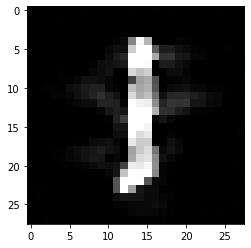

Iteration 110 distortion 1.5782 num_queries 26879
Iteration 120 distortion 1.5768 num_queries 29187
Iteration 130 distortion 1.5765 num_queries 32468
Succeed distortion 1.5765 target 8 queries 33004 LS queries 6512



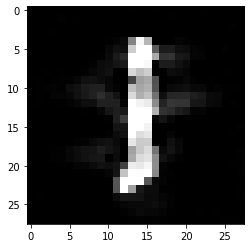

image batch: 15
Searching for the initial direction on 100 random directions: 
--------> Found distortion 11.2962
--------> Found distortion 9.5560
--------> Found distortion 8.8748
==========> Found best distortion 8.8748 in 0.1786 seconds using 240 queries
Iteration  10 distortion 1.4790 num_queries 3223
Iteration  20 distortion 1.0631 num_queries 5796
Iteration  30 distortion 0.9798 num_queries 8258
Iteration  40 distortion 0.9472 num_queries 10704
Iteration  50 distortion 0.9285 num_queries 13048
Iteration  60 distortion 0.9162 num_queries 15391
Iteration  70 distortion 0.9076 num_queries 17749
Iteration  80 distortion 0.9032 num_queries 20088
Iteration  90 distortion 0.8987 num_queries 22399
Iteration 100 distortion 0.8954 num_queries 24752


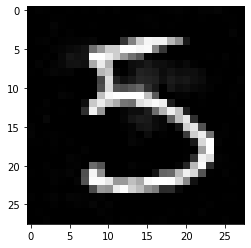

Succeed distortion 0.8948 target 3 queries 27401 LS queries 5761



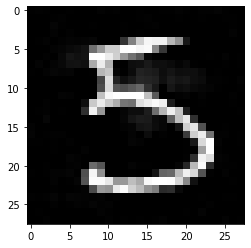

image batch: 16
Searching for the initial direction on 100 random directions: 
--------> Found distortion 11.5925
--------> Found distortion 11.5083
--------> Found distortion 10.1210
--------> Found distortion 9.1166
==========> Found best distortion 9.1166 in 0.1998 seconds using 252 queries
Iteration  10 distortion 1.4820 num_queries 3243
Iteration  20 distortion 1.2493 num_queries 5794
Iteration  30 distortion 1.1715 num_queries 8188
Iteration  40 distortion 1.1266 num_queries 10547
Iteration  50 distortion 1.1022 num_queries 12963
Iteration  60 distortion 1.0883 num_queries 15334
Iteration  70 distortion 1.0782 num_queries 17688
Iteration  80 distortion 1.0709 num_queries 20168
Iteration  90 distortion 1.0705 num_queries 23009
Succeed distortion 1.0705 target 4 queries 24532 LS queries 5480



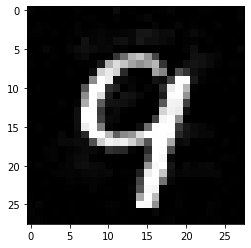

image batch: 17
Searching for the initial direction on 100 random directions: 
--------> Found distortion 18.8420
--------> Found distortion 15.3407
--------> Found distortion 14.2087
--------> Found distortion 13.2868
--------> Found distortion 12.4045
==========> Found best distortion 12.4045 in 0.1879 seconds using 240 queries
Iteration  10 distortion 2.7701 num_queries 3221
Iteration  20 distortion 2.3387 num_queries 5769
Iteration  30 distortion 2.2176 num_queries 8204
Iteration  40 distortion 2.1659 num_queries 10619
Iteration  50 distortion 2.1391 num_queries 13047
Iteration  60 distortion 2.1205 num_queries 15398
Iteration  70 distortion 2.1084 num_queries 17794
Iteration  80 distortion 2.1006 num_queries 20169
Iteration  90 distortion 2.0958 num_queries 23569

Failed: distortion 2.0957


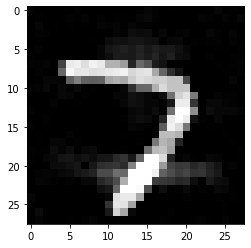

image batch: 18
Searching for the initial direction on 100 random directions: 
--------> Found distortion 15.0548
--------> Found distortion 14.9795
--------> Found distortion 9.3201
--------> Found distortion 8.4094
--------> Found distortion 8.0645
==========> Found best distortion 8.0645 in 0.2130 seconds using 265 queries
Iteration  10 distortion 1.4835 num_queries 3145
Iteration  20 distortion 1.3106 num_queries 5541
Iteration  30 distortion 1.2145 num_queries 7954
Iteration  40 distortion 1.1601 num_queries 10402
Iteration  50 distortion 1.1252 num_queries 12881
Iteration  60 distortion 1.1007 num_queries 15284
Iteration  70 distortion 1.0921 num_queries 18294
Succeed distortion 1.0921 target 8 queries 20425 LS queries 4960



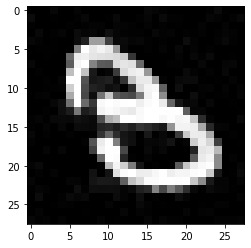

image batch: 19
Searching for the initial direction on 100 random directions: 
--------> Found distortion 18.0859
--------> Found distortion 17.3496
--------> Found distortion 13.9854
==========> Found best distortion 13.9854 in 0.1578 seconds using 207 queries
Iteration  10 distortion 2.2534 num_queries 3217
Iteration  20 distortion 1.7453 num_queries 5785
Iteration  30 distortion 1.6320 num_queries 8247
Iteration  40 distortion 1.5946 num_queries 10591
Iteration  50 distortion 1.5735 num_queries 12923
Iteration  60 distortion 1.5623 num_queries 15239
Iteration  70 distortion 1.5553 num_queries 17608
Iteration  80 distortion 1.5503 num_queries 19930
Succeed distortion 1.5494 target 9 queries 23072 LS queries 5265



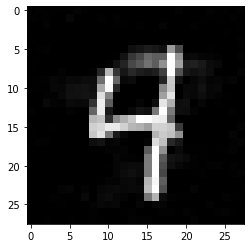

image batch: 20
Searching for the initial direction on 100 random directions: 
--------> Found distortion 13.0128
--------> Found distortion 11.6221
--------> Found distortion 11.3277
--------> Found distortion 8.9500
--------> Found distortion 8.0836
==========> Found best distortion 8.0836 in 0.2296 seconds using 266 queries
Iteration  10 distortion 1.2657 num_queries 3185
Iteration  20 distortion 1.0774 num_queries 5733
Iteration  30 distortion 0.9915 num_queries 8206
Iteration  40 distortion 0.9519 num_queries 10581
Iteration  50 distortion 0.9334 num_queries 12927
Iteration  60 distortion 0.9166 num_queries 15273
Iteration  70 distortion 0.9050 num_queries 17660
Iteration  80 distortion 0.8961 num_queries 20057
Iteration  90 distortion 0.8919 num_queries 22396
Iteration 100 distortion 0.8887 num_queries 25423


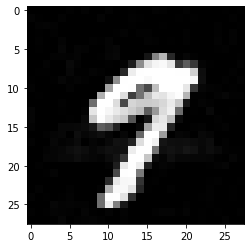

Succeed distortion 0.8887 target 7 queries 26719 LS queries 5853



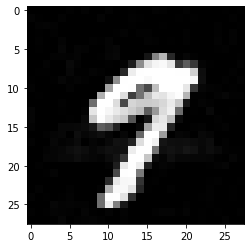

image batch: 21
Searching for the initial direction on 100 random directions: 
--------> Found distortion 15.8862
--------> Found distortion 13.1403
--------> Found distortion 12.4481
--------> Found distortion 10.2562
--------> Found distortion 10.1710
==========> Found best distortion 10.1710 in 0.1920 seconds using 265 queries
Iteration  10 distortion 2.2371 num_queries 3186
Iteration  20 distortion 1.8875 num_queries 5719
Iteration  30 distortion 1.7459 num_queries 8158
Iteration  40 distortion 1.7145 num_queries 10572
Iteration  50 distortion 1.6953 num_queries 12936
Iteration  60 distortion 1.6821 num_queries 15284
Iteration  70 distortion 1.6712 num_queries 17620
Iteration  80 distortion 1.6649 num_queries 19980
Iteration  90 distortion 1.6601 num_queries 22295
Iteration 100 distortion 1.6547 num_queries 24640


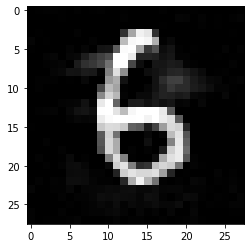

Iteration 110 distortion 1.6542 num_queries 27567
Succeed distortion 1.6540 target 8 queries 30277 LS queries 6412



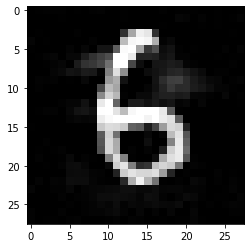

image batch: 22
Searching for the initial direction on 100 random directions: 
--------> Found distortion 18.2294
--------> Found distortion 15.8489
--------> Found distortion 14.4772
--------> Found distortion 13.5335
--------> Found distortion 12.9801
--------> Found distortion 11.5699
==========> Found best distortion 11.5699 in 0.2109 seconds using 276 queries
Iteration  10 distortion 2.7582 num_queries 3230
Iteration  20 distortion 2.2185 num_queries 5754
Iteration  30 distortion 2.0763 num_queries 8190
Iteration  40 distortion 2.0248 num_queries 10591
Iteration  50 distortion 1.9930 num_queries 12970
Iteration  60 distortion 1.9732 num_queries 15308
Iteration  70 distortion 1.9646 num_queries 17668
Iteration  80 distortion 1.9591 num_queries 20028
Iteration  90 distortion 1.9547 num_queries 22403
Iteration 100 distortion 1.9513 num_queries 24733


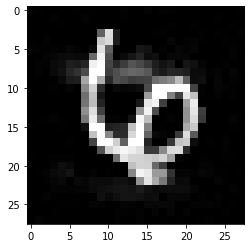

Iteration 110 distortion 1.9486 num_queries 27123
Iteration 120 distortion 1.9448 num_queries 29528
Iteration 130 distortion 1.9397 num_queries 31933
Iteration 140 distortion 1.9366 num_queries 34368
Iteration 150 distortion 1.9343 num_queries 36728
Iteration 160 distortion 1.9323 num_queries 39118
Iteration 170 distortion 1.9307 num_queries 41718
Succeed distortion 1.9306 target 8 queries 44669 LS queries 8793



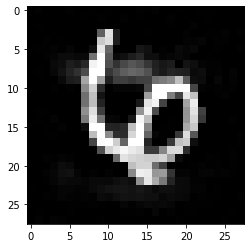

image batch: 23
Searching for the initial direction on 100 random directions: 
--------> Found distortion 15.3467
--------> Found distortion 11.7854
--------> Found distortion 11.4984
==========> Found best distortion 11.4984 in 0.1714 seconds using 240 queries
Iteration  10 distortion 2.8823 num_queries 3138
Iteration  20 distortion 2.3937 num_queries 5575
Iteration  30 distortion 2.2899 num_queries 8006
Iteration  40 distortion 2.2534 num_queries 10403
Iteration  50 distortion 2.2331 num_queries 12788
Iteration  60 distortion 2.2199 num_queries 15186
Iteration  70 distortion 2.2131 num_queries 17531
Iteration  80 distortion 2.2094 num_queries 19876
Iteration  90 distortion 2.2071 num_queries 22236
Iteration 100 distortion 2.2048 num_queries 24566


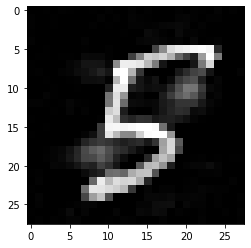

Iteration 110 distortion 2.2032 num_queries 26881
Iteration 120 distortion 2.2021 num_queries 29196
Iteration 130 distortion 2.2011 num_queries 31541

Failed: distortion 2.2011


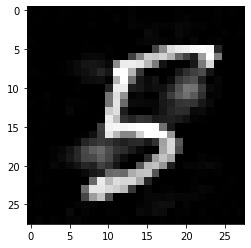

image batch: 24
Searching for the initial direction on 100 random directions: 
--------> Found distortion 17.9779
--------> Found distortion 17.0458
--------> Found distortion 15.1341
--------> Found distortion 14.3849
--------> Found distortion 14.0434
--------> Found distortion 14.0237
--------> Found distortion 11.9643
==========> Found best distortion 11.9643 in 0.2146 seconds using 265 queries
Iteration  10 distortion 1.5322 num_queries 3236
Iteration  20 distortion 1.1778 num_queries 5738
Iteration  30 distortion 1.1006 num_queries 8060
Iteration  40 distortion 1.0719 num_queries 10375
Iteration  50 distortion 1.0564 num_queries 12754
Iteration  60 distortion 1.0547 num_queries 15439
Iteration  70 distortion 1.0541 num_queries 18000
Iteration  80 distortion 1.0539 num_queries 20996
Succeed distortion 1.0539 target 9 queries 21911 LS queries 5046



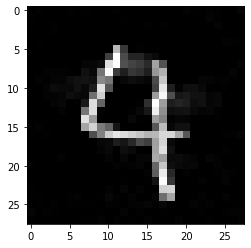

image batch: 25
Searching for the initial direction on 100 random directions: 
--------> Found distortion 18.2700
==========> Found best distortion 18.2700 in 0.1217 seconds using 163 queries
Iteration  10 distortion 3.2202 num_queries 3222
Iteration  20 distortion 2.5167 num_queries 5807
Iteration  30 distortion 2.3668 num_queries 8243
Iteration  40 distortion 2.2986 num_queries 10612
Iteration  50 distortion 2.2634 num_queries 12995
Iteration  60 distortion 2.2373 num_queries 15412
Iteration  70 distortion 2.2206 num_queries 17765
Iteration  80 distortion 2.2034 num_queries 20112
Iteration  90 distortion 2.1890 num_queries 22487
Iteration 100 distortion 2.1823 num_queries 24892


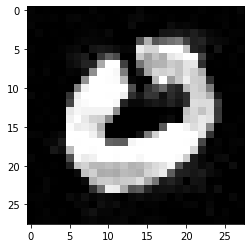

Iteration 110 distortion 2.1768 num_queries 27239
Iteration 120 distortion 2.1739 num_queries 29629
Iteration 130 distortion 2.1692 num_queries 32021
Iteration 140 distortion 2.1645 num_queries 34411
Iteration 150 distortion 2.1618 num_queries 36756
Iteration 160 distortion 2.1613 num_queries 39695

Failed: distortion 2.1613


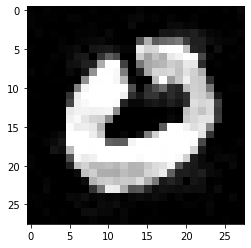

image batch: 26
Searching for the initial direction on 100 random directions: 
--------> Found distortion 14.1679
--------> Found distortion 14.0589
--------> Found distortion 10.6317
==========> Found best distortion 10.6317 in 0.1798 seconds using 234 queries
Iteration  10 distortion 1.9711 num_queries 3158
Iteration  20 distortion 1.6135 num_queries 5697
Iteration  30 distortion 1.5180 num_queries 8157
Iteration  40 distortion 1.4609 num_queries 10530
Iteration  50 distortion 1.4246 num_queries 12890
Iteration  60 distortion 1.4040 num_queries 15266
Iteration  70 distortion 1.3906 num_queries 17611
Iteration  80 distortion 1.3856 num_queries 19933
Iteration  90 distortion 1.3801 num_queries 22287
Iteration 100 distortion 1.3771 num_queries 24651


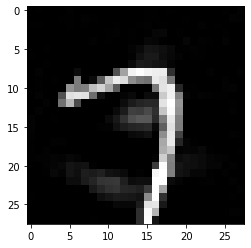

Iteration 110 distortion 1.3753 num_queries 27029
Iteration 120 distortion 1.3740 num_queries 29393
Iteration 130 distortion 1.3728 num_queries 31715
Iteration 140 distortion 1.3718 num_queries 34065
Iteration 150 distortion 1.3712 num_queries 36401
Iteration 160 distortion 1.3705 num_queries 39193
Succeed distortion 1.3705 target 3 queries 41021 LS queries 7987



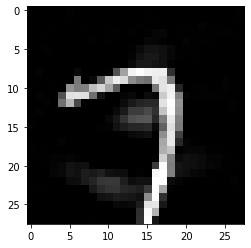

image batch: 27
Searching for the initial direction on 100 random directions: 
--------> Found distortion 17.3775
==========> Found best distortion 17.3775 in 0.1373 seconds using 151 queries
Iteration  10 distortion 2.6641 num_queries 3096
Iteration  20 distortion 2.0908 num_queries 5723
Iteration  30 distortion 1.8864 num_queries 8177
Iteration  40 distortion 1.8097 num_queries 10567
Iteration  50 distortion 1.7662 num_queries 12933
Iteration  60 distortion 1.7442 num_queries 15312
Iteration  70 distortion 1.7308 num_queries 17858
Iteration  80 distortion 1.7305 num_queries 21260
Succeed distortion 1.7305 target 9 queries 21260 LS queries 5109



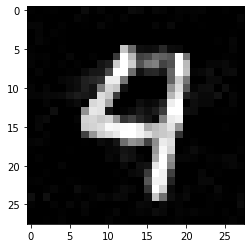

image batch: 28
Searching for the initial direction on 100 random directions: 
--------> Found distortion 24.7778
--------> Found distortion 23.0152
--------> Found distortion 22.4371
--------> Found distortion 18.7533
--------> Found distortion 18.1484
--------> Found distortion 16.5744
==========> Found best distortion 16.5744 in 0.1805 seconds using 234 queries
Iteration  10 distortion 3.0384 num_queries 3130
Iteration  20 distortion 2.5117 num_queries 5674
Iteration  30 distortion 2.3704 num_queries 8123
Iteration  40 distortion 2.3290 num_queries 10498
Iteration  50 distortion 2.3069 num_queries 12852
Iteration  60 distortion 2.2946 num_queries 15214
Iteration  70 distortion 2.2897 num_queries 17574
Iteration  80 distortion 2.2868 num_queries 19934
Iteration  90 distortion 2.2845 num_queries 22309

Failed: distortion 2.2844


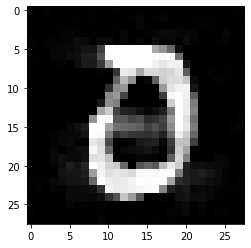

image batch: 29
Searching for the initial direction on 100 random directions: 
--------> Found distortion 8.1937
--------> Found distortion 8.1807
--------> Found distortion 7.6364
--------> Found distortion 6.9382
--------> Found distortion 6.6503
--------> Found distortion 6.6251
--------> Found distortion 6.6186
--------> Found distortion 6.2817
==========> Found best distortion 6.2817 in 0.2299 seconds using 299 queries
Iteration  10 distortion 1.8104 num_queries 3229
Iteration  20 distortion 1.2908 num_queries 5823
Iteration  30 distortion 1.1950 num_queries 8254
Iteration  40 distortion 1.1503 num_queries 10690
Iteration  50 distortion 1.1256 num_queries 13081
Iteration  60 distortion 1.1140 num_queries 15427
Iteration  70 distortion 1.1078 num_queries 17767
Iteration  80 distortion 1.1027 num_queries 20079
Iteration  90 distortion 1.1007 num_queries 22387
Iteration 100 distortion 1.0987 num_queries 24709


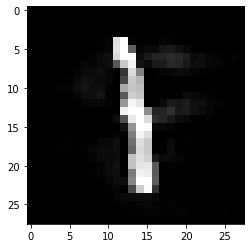

Iteration 110 distortion 1.0971 num_queries 27045
Iteration 120 distortion 1.0960 num_queries 29409
Iteration 130 distortion 1.0950 num_queries 31731
Iteration 140 distortion 1.0943 num_queries 34067
Iteration 150 distortion 1.0938 num_queries 36389
Iteration 160 distortion 1.0933 num_queries 38967
Succeed distortion 1.0933 target 8 queries 41020 LS queries 7721



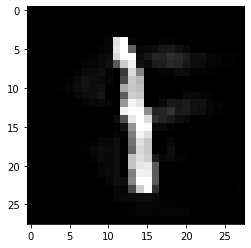

image batch: 30
Searching for the initial direction on 100 random directions: 
--------> Found distortion 21.9769
--------> Found distortion 19.1238
--------> Found distortion 19.1139
--------> Found distortion 19.0136
--------> Found distortion 18.0318
--------> Found distortion 17.6158
--------> Found distortion 14.9913
==========> Found best distortion 14.9913 in 0.2079 seconds using 260 queries
Iteration  10 distortion 4.2101 num_queries 3197
Iteration  20 distortion 3.4829 num_queries 5729
Iteration  30 distortion 3.2931 num_queries 8128
Iteration  40 distortion 3.2042 num_queries 10504
Iteration  50 distortion 3.1604 num_queries 12919
Iteration  60 distortion 3.1231 num_queries 15287
Iteration  70 distortion 3.1045 num_queries 17655
Iteration  80 distortion 3.0862 num_queries 20023
Iteration  90 distortion 3.0711 num_queries 22462
Iteration 100 distortion 3.0608 num_queries 24822


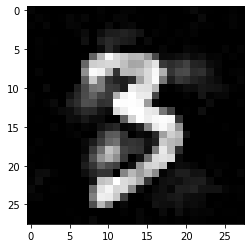

Iteration 110 distortion 3.0544 num_queries 27182
Iteration 120 distortion 3.0494 num_queries 29527
Iteration 130 distortion 3.0458 num_queries 31902
Iteration 140 distortion 3.0404 num_queries 34262
Iteration 150 distortion 3.0381 num_queries 36712

Failed: distortion 3.0369


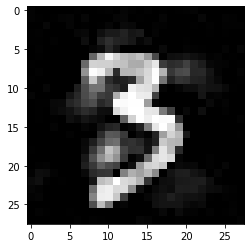

image batch: 31
Searching for the initial direction on 100 random directions: 
--------> Found distortion 8.9170
--------> Found distortion 8.7652
--------> Found distortion 8.4480
--------> Found distortion 8.1592
--------> Found distortion 7.0636
==========> Found best distortion 7.0636 in 0.1966 seconds using 265 queries
Iteration  10 distortion 1.5979 num_queries 3113
Iteration  20 distortion 1.4105 num_queries 5576
Iteration  30 distortion 1.3206 num_queries 8004
Iteration  40 distortion 1.2913 num_queries 10341
Iteration  50 distortion 1.2731 num_queries 12727
Iteration  60 distortion 1.2660 num_queries 15067
Iteration  70 distortion 1.2614 num_queries 17473
Iteration  80 distortion 1.2584 num_queries 19781
Iteration  90 distortion 1.2552 num_queries 22117
Iteration 100 distortion 1.2519 num_queries 24453


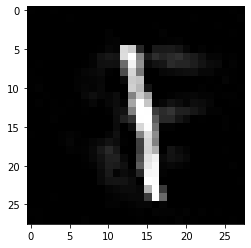

Iteration 110 distortion 1.2474 num_queries 26789
Iteration 120 distortion 1.2448 num_queries 29083
Succeed distortion 1.2440 target 8 queries 31960 LS queries 6295



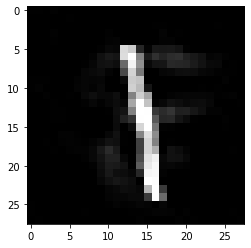

image batch: 32
Searching for the initial direction on 100 random directions: 
--------> Found distortion 19.1406
--------> Found distortion 18.1003
--------> Found distortion 17.7827
--------> Found distortion 15.9565
--------> Found distortion 14.9135
==========> Found best distortion 14.9135 in 0.1888 seconds using 251 queries
Iteration  10 distortion 4.5898 num_queries 3039
Iteration  20 distortion 2.9368 num_queries 5716
Iteration  30 distortion 2.6556 num_queries 8222
Iteration  40 distortion 2.5869 num_queries 10622
Iteration  50 distortion 2.5523 num_queries 13006
Iteration  60 distortion 2.5261 num_queries 15370
Iteration  70 distortion 2.5122 num_queries 17720
Iteration  80 distortion 2.5003 num_queries 20129
Iteration  90 distortion 2.4948 num_queries 22474
Iteration 100 distortion 2.4902 num_queries 24879


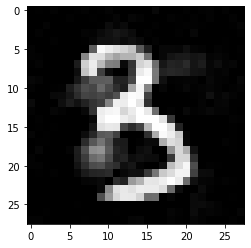

Iteration 110 distortion 2.4872 num_queries 27224
Iteration 120 distortion 2.4842 num_queries 29689
Iteration 130 distortion 2.4818 num_queries 32064
Iteration 140 distortion 2.4798 num_queries 34409
Iteration 150 distortion 2.4777 num_queries 36829
Iteration 160 distortion 2.4769 num_queries 39234
Iteration 170 distortion 2.4756 num_queries 41579
Iteration 180 distortion 2.4746 num_queries 43939

Failed: distortion 2.4742


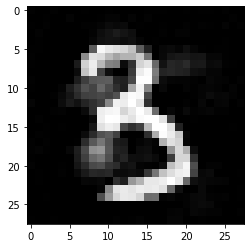

image batch: 33
Searching for the initial direction on 100 random directions: 
--------> Found distortion 27.3642
--------> Found distortion 23.5557
--------> Found distortion 22.1892
--------> Found distortion 20.0033
--------> Found distortion 18.5132
==========> Found best distortion 18.5132 in 0.1629 seconds using 204 queries
Iteration  10 distortion 3.8286 num_queries 3071
Iteration  20 distortion 2.5492 num_queries 5783
Iteration  30 distortion 2.3446 num_queries 8253
Iteration  40 distortion 2.2555 num_queries 10692
Iteration  50 distortion 2.2233 num_queries 13096
Iteration  60 distortion 2.2095 num_queries 15426
Iteration  70 distortion 2.2005 num_queries 17866
Iteration  80 distortion 2.1935 num_queries 20226
Iteration  90 distortion 2.1868 num_queries 22586
Iteration 100 distortion 2.1808 num_queries 24931


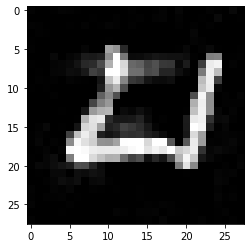

Iteration 110 distortion 2.1763 num_queries 27291
Iteration 120 distortion 2.1738 num_queries 30065

Failed: distortion 2.1738


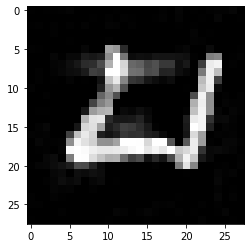

image batch: 34
Searching for the initial direction on 100 random directions: 
--------> Found distortion 19.8532
--------> Found distortion 17.5945
--------> Found distortion 17.0414
--------> Found distortion 12.3250
--------> Found distortion 11.2793
==========> Found best distortion 11.2793 in 0.2160 seconds using 266 queries
Iteration  10 distortion 2.9006 num_queries 3223
Iteration  20 distortion 2.3320 num_queries 5840
Iteration  30 distortion 2.1843 num_queries 8302
Iteration  40 distortion 2.1038 num_queries 10653
Iteration  50 distortion 2.0354 num_queries 13010
Iteration  60 distortion 2.0095 num_queries 15453
Iteration  70 distortion 1.9883 num_queries 17820
Iteration  80 distortion 1.9694 num_queries 20201
Iteration  90 distortion 1.9591 num_queries 22534
Iteration 100 distortion 1.9499 num_queries 24942


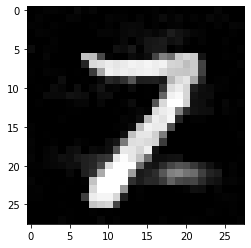

Iteration 110 distortion 1.9447 num_queries 27272
Iteration 120 distortion 1.9400 num_queries 29632
Iteration 130 distortion 1.9370 num_queries 31977
Iteration 140 distortion 1.9344 num_queries 34382
Iteration 150 distortion 1.9317 num_queries 36727
Iteration 160 distortion 1.9289 num_queries 39132
Iteration 170 distortion 1.9276 num_queries 42120
Succeed distortion 1.9276 target 2 queries 42989 LS queries 8323



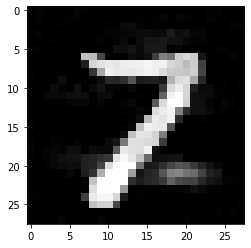

image batch: 35
Searching for the initial direction on 100 random directions: 
--------> Found distortion 23.9416
--------> Found distortion 23.7765
--------> Found distortion 19.2712
--------> Found distortion 15.4755
--------> Found distortion 15.3612
==========> Found best distortion 15.3612 in 0.1660 seconds using 221 queries
Iteration  10 distortion 4.0922 num_queries 3103
Iteration  20 distortion 3.4744 num_queries 5604
Iteration  30 distortion 3.3237 num_queries 8019
Iteration  40 distortion 3.2525 num_queries 10431
Iteration  50 distortion 3.2183 num_queries 12788
Iteration  60 distortion 3.1916 num_queries 15156
Iteration  70 distortion 3.1737 num_queries 17524
Iteration  80 distortion 3.1622 num_queries 19929
Iteration  90 distortion 3.1570 num_queries 22274
Iteration 100 distortion 3.1524 num_queries 24649


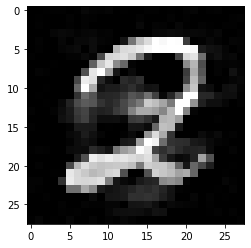

Iteration 110 distortion 3.1475 num_queries 27024
Iteration 120 distortion 3.1454 num_queries 29414
Iteration 130 distortion 3.1435 num_queries 31789

Failed: distortion 3.1426


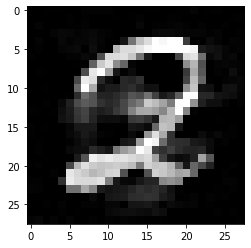

image batch: 36
Searching for the initial direction on 100 random directions: 
--------> Found distortion 17.1144
--------> Found distortion 16.4292
--------> Found distortion 14.7024
--------> Found distortion 9.5282
--------> Found distortion 9.3654
==========> Found best distortion 9.3654 in 0.2184 seconds using 262 queries
Iteration  10 distortion 1.5402 num_queries 3224
Iteration  20 distortion 1.2604 num_queries 5766
Iteration  30 distortion 1.1704 num_queries 8159
Iteration  40 distortion 1.1326 num_queries 10528
Iteration  50 distortion 1.1126 num_queries 12964
Iteration  60 distortion 1.1005 num_queries 15336
Iteration  70 distortion 1.0933 num_queries 17690
Iteration  80 distortion 1.0883 num_queries 20012
Iteration  90 distortion 1.0844 num_queries 22348
Iteration 100 distortion 1.0802 num_queries 24712


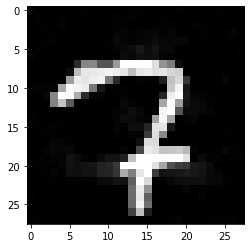

Iteration 110 distortion 1.0787 num_queries 27400
Succeed distortion 1.0787 target 2 queries 28723 LS queries 5861



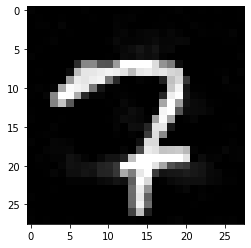

image batch: 37
Searching for the initial direction on 100 random directions: 
--------> Found distortion 13.0367
--------> Found distortion 8.7121
--------> Found distortion 8.3000
--------> Found distortion 7.3035
==========> Found best distortion 7.3035 in 0.2055 seconds using 253 queries
Iteration  10 distortion 1.8828 num_queries 3131
Iteration  20 distortion 1.5163 num_queries 5649
Iteration  30 distortion 1.4215 num_queries 8064
Iteration  40 distortion 1.3880 num_queries 10438
Iteration  50 distortion 1.3698 num_queries 12814
Iteration  60 distortion 1.3610 num_queries 15178
Iteration  70 distortion 1.3553 num_queries 17556
Iteration  80 distortion 1.3520 num_queries 19864
Iteration  90 distortion 1.3495 num_queries 22172
Iteration 100 distortion 1.3479 num_queries 24508


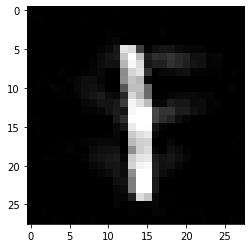

Iteration 110 distortion 1.3469 num_queries 26816
Iteration 120 distortion 1.3462 num_queries 29194
Succeed distortion 1.3461 target 8 queries 32157 LS queries 6304



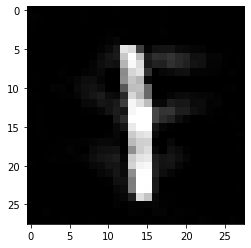

image batch: 38
Searching for the initial direction on 100 random directions: 
--------> Found distortion 17.1043
--------> Found distortion 16.1188
--------> Found distortion 11.8127
--------> Found distortion 9.3289
--------> Found distortion 8.9411
--------> Found distortion 8.7452
--------> Found distortion 7.7348
--------> Found distortion 7.5998
==========> Found best distortion 7.5998 in 0.2443 seconds using 301 queries
Iteration  10 distortion 1.2128 num_queries 3208
Iteration  20 distortion 1.0345 num_queries 5749
Iteration  30 distortion 0.9741 num_queries 8170
Succeed distortion 0.9692 target 3 queries 11193 LS queries 3492



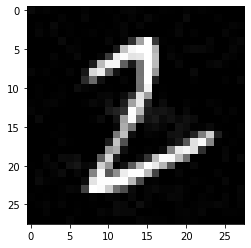

image batch: 39
Searching for the initial direction on 100 random directions: 
--------> Found distortion 12.3863
--------> Found distortion 9.5762
--------> Found distortion 8.6469
--------> Found distortion 8.3345
--------> Found distortion 7.7052
--------> Found distortion 7.5773
==========> Found best distortion 7.5773 in 0.2156 seconds using 278 queries
Iteration  10 distortion 1.6094 num_queries 3218
Iteration  20 distortion 1.3016 num_queries 5736
Iteration  30 distortion 1.2367 num_queries 8146
Iteration  40 distortion 1.2150 num_queries 10506
Iteration  50 distortion 1.2032 num_queries 12864
Iteration  60 distortion 1.1983 num_queries 15172
Iteration  70 distortion 1.1964 num_queries 17494
Iteration  80 distortion 1.1939 num_queries 19830
Iteration  90 distortion 1.1922 num_queries 22152
Iteration 100 distortion 1.1915 num_queries 24474


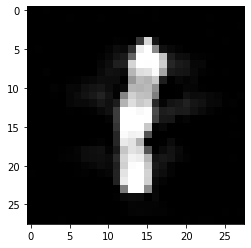

Iteration 110 distortion 1.1910 num_queries 27647
Succeed distortion 1.1910 target 8 queries 28225 LS queries 5747



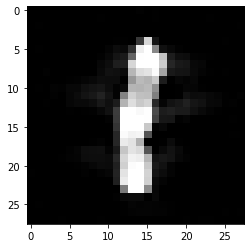

image batch: 40
clean count: 40
acc under attack count: 0
avg total queries used: 1280633
avg stop queries used: 29031.678571428572
average distortion: 1.672504523396492
robust accuracy: 0.30000000000000004


In [ ]:
amodel = PytorchModel(net, bounds=[0, 1], num_classes=10)
attack = OPT_attack_sign_SGD(amodel)

total_r_count = 0
total_clean_count = 0
total_distance = 0
successes = []
stop_queries = []

for i, (xi, yi) in enumerate(test_loader):
    print(f"image batch: {i}")
    if i == args.test_batch:
        break

    xi, yi = xi.cuda(), yi.cuda()
    adv, distortion, is_success, nqueries, theta_signopt = attack(xi, yi, targeted=args.targeted, query_limit=args.query, distortion=args.epsilon, args=args)

    # 결과 출력(l_2 distortion이 충분히 감소했을 때 성공)
    img = torchvision.transforms.ToPILImage()(torch.clamp(adv, min=0, max=1).squeeze(0))
    plt.imshow(img, cmap='gray') # for grayscale
    plt.show()

    if is_success:
        stop_queries.append(nqueries)

    if args.targeted == False:
        r_count = (torch.max(amodel.predict(adv), 1)[1] == yi).nonzero().shape[0]
        clean_count = (torch.max(amodel.predict(xi), 1)[1] == yi).nonzero().shape[0]
        total_r_count += r_count
        total_clean_count += clean_count
        total_distance += distance(adv, xi, norm=args.norm)

    successes.append(is_success)

num_queries = amodel.get_num_queries()
print(f"clean count: {total_clean_count}")
print(f"acc under attack count: {total_r_count}")
print(f"avg total queries used: {num_queries}")
print(f"avg stop queries used: {np.mean(stop_queries)}")
print(f"average distortion: {total_distance / (args.test_batch * test_batch_size)}")
print("robust accuracy: {}".format(1 - np.mean(successes)))